In [3]:
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import imblearn.over_sampling
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
df_X = pd.read_csv('instacart_df_X_features_subset.csv')
# df_X2 = pd.read_csv('instacart_df_X2_features_subset.csv')

In [5]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298523 entries, 0 to 1298522
Data columns (total 42 columns):
Unnamed: 0                                        1298523 non-null int64
product_id                                        1298523 non-null int64
user_id                                           1298523 non-null int64
user_product_total_orders                         1298523 non-null int64
latest_cart                                       1298523 non-null object
in_cart                                           1298523 non-null int64
product_total_orders                              1298523 non-null int64
product_avg_add_to_cart_order                     1298523 non-null float64
product_avg_order_number                          1298523 non-null float64
product_avg_dow                                   1298523 non-null float64
product_avg_hour_of_day                           1298523 non-null float64
product_total_times_reordered                     1298523 non-null int64
pr

In [3]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_te, y_tr, y_te, df_tr

In [6]:
def testing_logistic(df, seed=42):
    X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X, seed=seed)
    X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr, seed=seed)

    scale = StandardScaler()
    X_tr_scaled = scale.fit_transform(X_tr)
    X_te_scaled = scale.transform(X_te)

    lr = LogisticRegression()
    lr.fit(X_tr_scaled, y_tr)
    print('Logistic Regression F1 score', f1_score(lr.predict(X_te_scaled), y_te))

    thresh_ps = np.linspace(.10,.50,1000)
    
    model_te_probs = lr.predict_proba(X_te_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_te_labels = model_te_probs >= p
        f1_scores.append(f1_score(model_te_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

In [5]:
def testing_random_forest(df, seed=42, n_estimators=100):
    X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X, seed=seed)
    X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr, seed=seed)

    rf = RandomForestClassifier(n_estimators=n_estimators,random_state=seed,n_jobs=-1)
    rf.fit(X_tr, y_tr)
    print('Random Forest F1 score', f1_score(rf.predict(X_te), y_te))

    thresh_ps = np.linspace(.10,.50,1000)
    

    model_te_probs = rf.predict_proba(X_te)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_te_labels = model_te_probs >= p
        f1_scores.append(f1_score(model_te_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Random Forest Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

In [29]:
testing_logistic(df_X)
testing_logistic(df_X2)

Logistic Regression F1 score 0.263811890651883
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186
Logistic Regression F1 score 0.263811890651883
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186


In [30]:
testing_random_forest(df_X)
testing_random_forest(df_X2)

Random Forest F1 score 0.2569508804448563
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240
Random Forest F1 score 0.2569508804448563
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240


In [31]:
testing_random_forest(df_X, n_estimators=200)
testing_random_forest(df_X2, n_estimators=200)

Random Forest F1 score 0.2598276061999923
Random Forest Regression Model best F1 score 0.424 at prob decision threshold >= 0.240
Random Forest F1 score 0.2598276061999923
Random Forest Regression Model best F1 score 0.424 at prob decision threshold >= 0.240


In [134]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 8 0.438
#best subsample: 0.7 0.438
#best min_child_weight: 10 0.438
#best colsample_bytree: 0.8 0.438
#With learning_rate set to 0.1 0.438

X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

gbm = xgb.XGBClassifier(
                        n_estimators=30000, #arbitrary large number
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=0.7,
                        min_child_weight=10,
                        colsample_bytree=0.8,
                       )

eval_set=[(X_tr,y_tr),(X_te,y_te)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=50,
                    verbose=False
                   )

f1_score(y_te, gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)) 

/Users/andersolson-swanson/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2744513267569014

In [135]:
model_te_probs = gbm.predict_proba(X_te, ntree_limit=gbm.best_ntree_limit)[:,1] # positive class probs, same basic logistic model we fit in section 2 
thresh_ps = np.linspace(.10,.50,1000)
f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Boosting Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Boosting Model best F1 score 0.436 at prob decision threshold >= 0.201


# Score against my holdout

In [137]:
model_h_probs = gbm.predict_proba(X_h, ntree_limit=gbm.best_ntree_limit)[:,1] # positive class probs, same basic logistic model we fit in section 2 
model_h_labels = model_h_probs >= 0.201
f1_score(model_h_labels, y_h)

0.43046632468416424

In [138]:
with open('gbm_seed42.pkl', 'wb') as picklefile:
    pickle.dump(gbm, picklefile)

# Creating table for Tableau

In [140]:
y_all= df_X['in_cart']
X_all = df_X.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 

In [141]:
model_all_probs = gbm.predict_proba(X_all, ntree_limit=gbm.best_ntree_limit)[:,1]
model_all_labels = model_all_probs >= 0.201
f1_score(model_all_labels, y_all)

0.4503724106730005

Text(0.5,1,'Feature Importance')

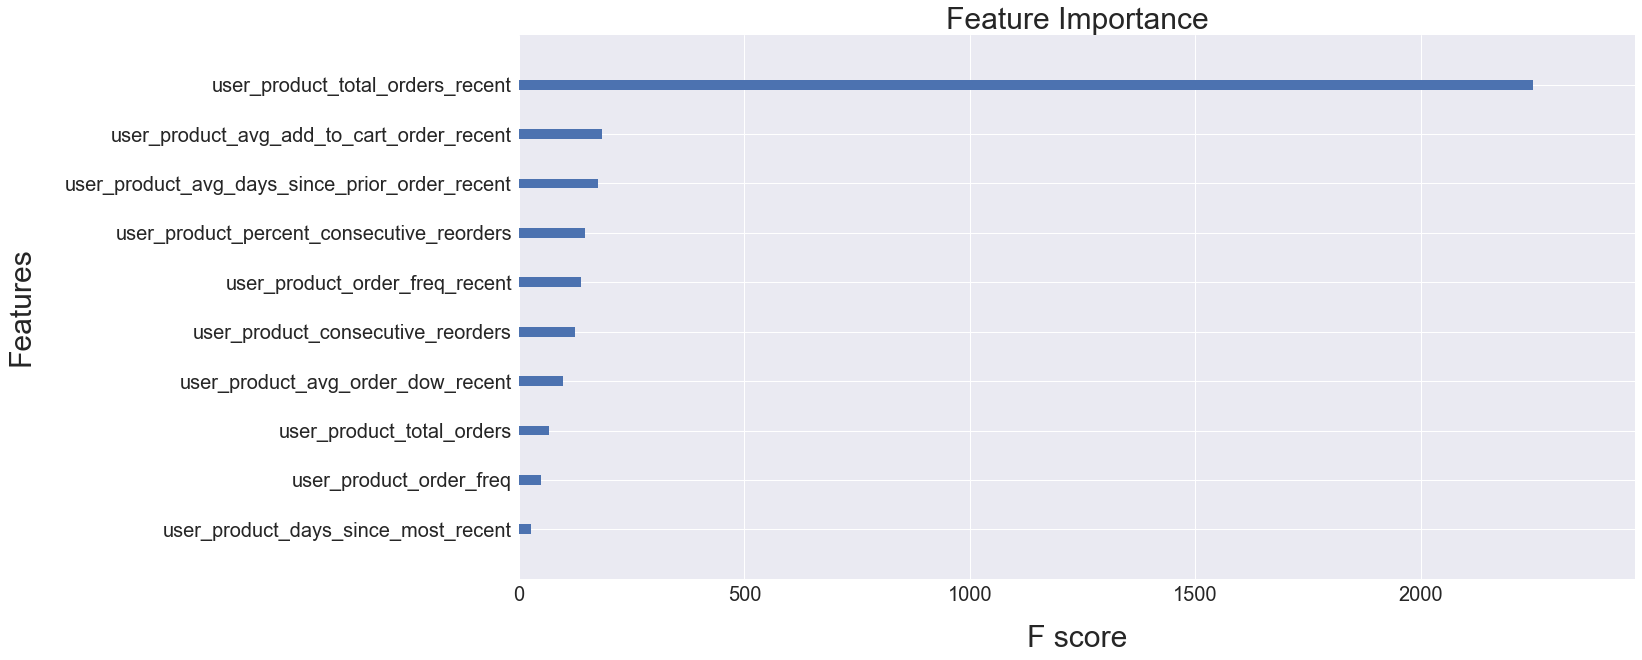

In [150]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(gbm, importance_type='gain', ax=ax, show_values=False, max_num_features=10)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.ylabel('Features', fontsize=30, labelpad=30)
plt.xlabel('F score', fontsize=30, labelpad=20)
plt.title('Feature Importance', fontsize=30)

In [143]:
df_X_tableau = pd.read_csv('instacart_df_X_features_subset.csv')

In [82]:
with open('products.pkl', 'rb') as picklefile:
    products = pickle.load(picklefile)

In [144]:
df_X_tableau = df_X_tableau.merge(products, on=['product_id'])

In [145]:
df_X_tableau['probs_from_model'] = model_all_probs
df_X_tableau['reordered_from_model'] = model_all_labels.astype(int)

In [146]:
df_X_tableau.to_csv('df_X_tableau_subset.csv', index=False)

In [7]:
df_X_tableau = pd.read_csv('df_X_tableau_subset.csv')

In [154]:
with open('order_products_prior_sample.pkl', 'rb') as picklefile:
    df_order_products_prior = pickle.load(picklefile)

In [9]:
df_X_tableau2 = (df_X_tableau.groupby(['product_id','product_name','department_id','department','aisle_id','aisle'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('product_total_orders','max'),
                                                      ('product_avg_add_to_cart_order', 'max'),
                                                      ('product_avg_order_number', 'max'),
                                                      ('product_avg_dow', 'max'),
                                                      ('product_avg_hour_of_day', 'max'),
                                                      ('product_total_times_reordered', 'max'),
                                                      ('product_reordered_rate', 'max'),
                                                      ('product_avg_dow_delta', 'max'),
                                                      ('product_avg_hod_delta', 'max'),
                                                      ('probs_from_model', 'mean')])))



In [11]:
df_X_tableau2.to_csv('df_X_tableau2_subset.csv', index=False)